Let's do an excercise where I get ChatGPT to create synthetic data with some conditions, and then let it analyse it in a guided way.

First, a summary of the data generation rules given to ChatGPT (who was prompted to assume to role of an expert data scientist)

# Summary of the rules and assumptions used to generate the synthetic dataset:

## Classrooms & Students:
- There were 10 classrooms in total, with 30 students each, resulting in 300 students.
- All students were aged between 18 and 20 years.

## Demographics:
- The demographics matched those of 18-20-year-olds in Canada in terms of gender, socioeconomic status, and handedness.

## Teaching Techniques:
- Half of the classrooms were taught with "Technique 1" and the other half with "Technique 2".

## Grading & Tests:
- All tests were graded out of 100.
- The students took a total of three tests:
    - Test 1 (Time 1): Before being taught any technique.
    - Test 2 (Time 2) & Test 3 (Time 3): After being taught the respective techniques.
    - Test scores for Time 1 were similar for both techniques.
    - Test scores for Times 2 and 3 were closely correlated.

## Score Generation:
- For Technique 1:
  - Time 1: Scores were randomly generated with a mean of 65.
  - Time 2: Scores had a higher mean (75) to show improvement.
  - Time 3: Scores had an even higher mean (78) to show further improvement.
- For Technique 2:
  - Time 1: Scores were randomly generated with a mean of 65, matching Technique 1's baseline.
  - Time 2: Scores were slightly improved but less than Technique 1, with a mean of 68.
  - Time 3: Scores showed a slight further improvement with a mean of 70.

## Variability:
- Individual differences in scores were introduced to make the dataset realistic. This variability was achieved using random number generation based on a normal distribution around the predefined means.
- Additionally, slight variations between classrooms were introduced, even if they were taught with the same technique, to account for factors like different instructors, classroom environments, etc.

The dataset was designed so that Technique 1 would show a more pronounced improvement in student grades at Times 2 and 3 compared to Technique 2.

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

In [3]:
# Constants
CLASSROOMS = 10
STUDENTS_PER_CLASS = 30

# Create empty list for temporary dataframes
temp_dfs = []

# Generate classroom and student data
class_ids = list(range(1, CLASSROOMS+1))
class_techniques = ['Technique 1']*5 + ['Technique 2']*5
np.random.shuffle(class_techniques)  # Shuffle to randomize

# Demographics
ages = list(range(18, 21))  # Ages 18-20
genders = ["Male", "Female"]
socio_status = ["Low", "Medium", "High"]
handedness = ["Left", "Right"]

for class_id, technique in zip(class_ids, class_techniques):
    students = range(1, STUDENTS_PER_CLASS+1)
    for student in students:
        student_data = {
            "Classroom": class_id,
            "Student_ID": f"C{class_id}S{student}",
            "Technique": technique,
            "Age": np.random.choice(ages),
            "Gender": np.random.choice(genders),
            "Socioeconomic_Status": np.random.choice(socio_status),
            "Handedness": np.random.choice(handedness),
            "Test1_Score": np.random.normal(65, 10),  # Similar distribution for both techniques
        }
        temp_dfs.append(pd.DataFrame([student_data]))

# Concatenate all temporary DataFrames
df = pd.concat(temp_dfs, ignore_index=True)

# Generate test scores based on technique
for i, row in df.iterrows():
    test1_score = row["Test1_Score"]
    if row["Technique"] == "Technique 1":
        test2_score = np.random.normal(75, 10)  # Higher mean for Technique 1
        test3_score = test2_score + np.random.normal(0, 5)  # Correlation with Test 2
    else:
        test2_score = test1_score + np.random.normal(0, 5)  # Correlation with Test 1 for Technique 2
        test3_score = test2_score + np.random.normal(0, 5)  # Correlation with Test 2 for Technique 2
    
    df.at[i, "Test2_Score"] = test2_score
    df.at[i, "Test3_Score"] = test3_score

# Ensure scores are capped at 100 and floored at 0
df["Test1_Score"] = df["Test1_Score"].clip(0, 100)
df["Test2_Score"] = df["Test2_Score"].clip(0, 100)
df["Test3_Score"] = df["Test3_Score"].clip(0, 100)

print(df)

     Classroom Student_ID    Technique  Age  Gender Socioeconomic_Status  \
0            1       C1S1  Technique 1   20  Female                 High   
1            1       C1S2  Technique 1   19    Male                  Low   
2            1       C1S3  Technique 1   18  Female                  Low   
3            1       C1S4  Technique 1   19    Male               Medium   
4            1       C1S5  Technique 1   18  Female                  Low   
..         ...        ...          ...  ...     ...                  ...   
295         10     C10S26  Technique 2   20    Male                  Low   
296         10     C10S27  Technique 2   19  Female                  Low   
297         10     C10S28  Technique 2   18    Male               Medium   
298         10     C10S29  Technique 2   18    Male                 High   
299         10     C10S30  Technique 2   19  Female                  Low   

    Handedness  Test1_Score  Test2_Score  Test3_Score  
0        Right    67.386840   1

With the data generated, I asked it to give me some descriptive stats. Some prodding required to give it in a form which can be displayed nicely

In [10]:
# Grouping by the teaching technique and then calculating the descriptive stats for each test
desc_stats = df.groupby('Technique').agg({
    'Test1_Score': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'Test2_Score': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'Test3_Score': ['count', 'mean', 'median', 'std', 'min', 'max']
})

# Reshape the data for a cleaner look
desc_stats = desc_stats.stack(level=0).reset_index().rename(columns={'level_1': 'Test'})
desc_stats.set_index(['Technique', 'Test'], inplace=True)

display(desc_stats)

count         max       mean     median        min  \
Technique   Test                                                              
Technique 1 Test1_Score    150   96.936012  64.638309  64.474936  26.263679   
            Test2_Score    150  100.000000  74.614195  74.451671  48.138027   
            Test3_Score    150  100.000000  74.586939  74.846629  48.324974   
Technique 2 Test1_Score    150   86.993342  66.311804  66.651727  47.039162   
            Test2_Score    150   88.344523  66.541432  66.975216  43.405017   
            Test3_Score    150   90.771186  66.292818  66.293055  38.359623   

                               std  
Technique   Test                    
Technique 1 Test1_Score  10.194459  
            Test2_Score   9.492132  
            Test3_Score  10.450021  
Technique 2 Test1_Score   8.901313  
            Test2_Score   9.840946  
            Test3_Score  11.474281

I asked for suggetions for data visualizations and boxplots, scatterplots and historgrams were suggested. I asked it to start with boxplot and then overlapping histograms. I put the panels together into one figure.

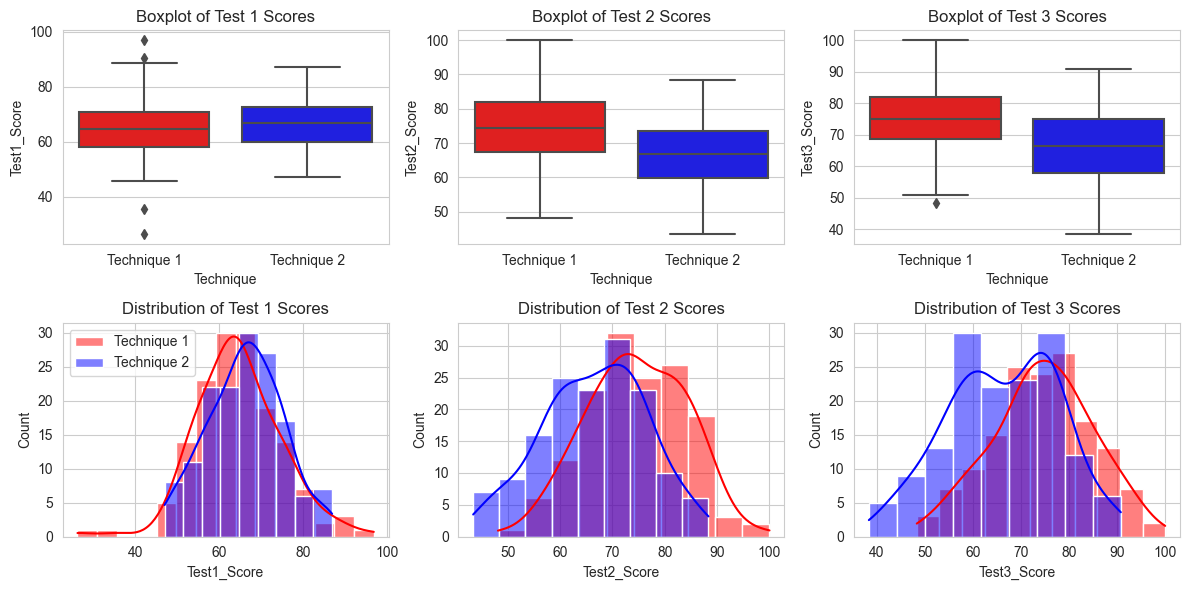

In [23]:
# Setting up the aesthetics for the plot
sns.set_style("whitegrid")
# Define the colors for each technique
colors = {"Technique 1": "red", "Technique 2": "blue"}

# Create a larger figure for the plots
plt.figure(figsize=(12, 6))

# Plot for Test1_Score
plt.subplot(2, 3, 1)
sns.boxplot(x='Technique', y='Test1_Score', data=df, palette=colors)
plt.title('Boxplot of Test 1 Scores')

# Plot for Test2_Score
plt.subplot(2, 3, 2)
sns.boxplot(x='Technique', y='Test2_Score', data=df, palette=colors)
plt.title('Boxplot of Test 2 Scores')

# Plot for Test3_Score
plt.subplot(2, 3, 3)
sns.boxplot(x='Technique', y='Test3_Score', data=df, palette=colors)
plt.title('Boxplot of Test 3 Scores')


# Plot histogram for Test1_Score
plt.subplot(2, 3, 4)
for technique, color in colors.items():
    sns.histplot(df[df['Technique'] == technique]['Test1_Score'], color=color, label=technique, kde=True, alpha=0.5)
plt.title('Distribution of Test 1 Scores')
plt.legend()

# Plot histogram for Test2_Score
plt.subplot(2, 3, 5)
for technique, color in colors.items():
    sns.histplot(df[df['Technique'] == technique]['Test2_Score'], color=color, label=technique, kde=True, alpha=0.5)
plt.title('Distribution of Test 2 Scores')
plt.legend([], [], frameon=False)

# Plot histogram for Test3_Score
plt.subplot(2, 3, 6)
for technique, color in colors.items():
    sns.histplot(df[df['Technique'] == technique]['Test3_Score'], color=color, label=technique, kde=True, alpha=0.5)
plt.title('Distribution of Test 3 Scores')
plt.legend([], [], frameon=False)
    
# Display the plots
plt.tight_layout()
plt.show()

I then asked it for a line plot with means and standard errors. It gave me standard deviations, but it was an easy enough change.

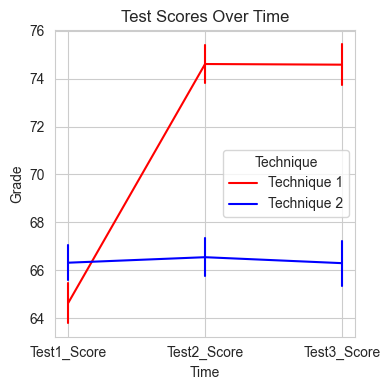

In [24]:
# Reshape the data to a long format
df_melted = df.melt(id_vars=['Technique'], value_vars=['Test1_Score', 'Test2_Score', 'Test3_Score'], 
                    var_name='Time', value_name='Grade')

# Compute means and standard errors
df_means = df_melted.groupby(['Technique', 'Time']).mean().reset_index()
df_errors = df_melted.groupby(['Technique', 'Time']).sem().reset_index()

# Create the line plot
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_melted, x='Time', y='Grade', hue='Technique', 
             palette={'Technique 1': 'red', 'Technique 2': 'blue'}, 
             err_style="bars", errorbar="se")

plt.title('Test Scores Over Time')
plt.ylabel('Grade')
plt.xlabel('Time')
plt.legend(title='Technique')
plt.tight_layout()
plt.show()

I then asked it for scatterplots with r-squared and p-values. Prompted it to add the y=x line and to overlay both techniques on the same graph. It also only gave be time 1 vs time 2 and time 1 vs time 3. Asked it for time 2 and time 3.

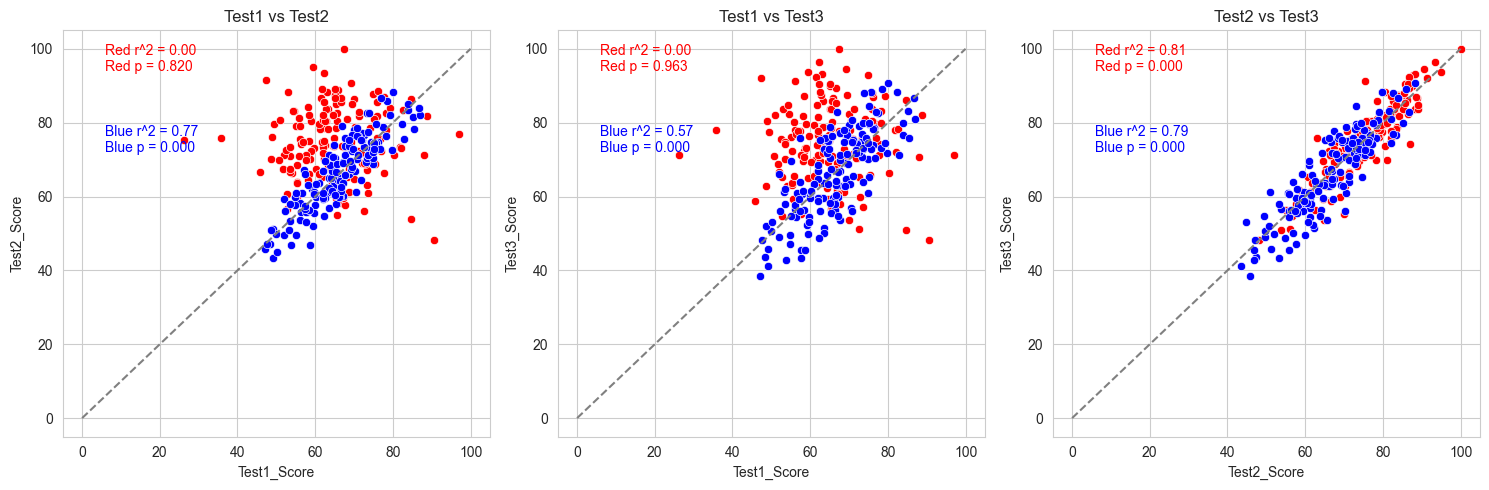

In [28]:
def annotate_with_r_and_p(data, x, y, ax, color):
    r, p = pearsonr(data[x], data[y])
    ax.annotate(f'{color} r^2 = {r**2:.2f}\n{color} p = {p:.3f}', xy=(0.1, 0.9 if color == 'Red' else 0.7), xycoords='axes fraction', color=color.lower())

plt.figure(figsize=(15, 5))

# Scatter plot for Test1 vs Test2
plt.subplot(1, 3, 1)
sns.scatterplot(data=df[df['Technique'] == 'Technique 1'], x='Test1_Score', y='Test2_Score', color='red', label='Technique 1')
sns.scatterplot(data=df[df['Technique'] == 'Technique 2'], x='Test1_Score', y='Test2_Score', color='blue', label='Technique 2')
plt.plot([0, 100], [0, 100], color='gray', linestyle='--')
plt.title('Test1 vs Test2')
annotate_with_r_and_p(df[df['Technique'] == 'Technique 1'], 'Test1_Score', 'Test2_Score', plt.gca(), 'Red')
annotate_with_r_and_p(df[df['Technique'] == 'Technique 2'], 'Test1_Score', 'Test2_Score', plt.gca(), 'Blue')
plt.legend([], [], frameon=False)

# Scatter plot for Test1 vs Test3
plt.subplot(1, 3, 2)
sns.scatterplot(data=df[df['Technique'] == 'Technique 1'], x='Test1_Score', y='Test3_Score', color='red', label='Technique 1')
sns.scatterplot(data=df[df['Technique'] == 'Technique 2'], x='Test1_Score', y='Test3_Score', color='blue', label='Technique 2')
plt.plot([0, 100], [0, 100], color='gray', linestyle='--')
plt.title('Test1 vs Test3')
annotate_with_r_and_p(df[df['Technique'] == 'Technique 1'], 'Test1_Score', 'Test3_Score', plt.gca(), 'Red')
annotate_with_r_and_p(df[df['Technique'] == 'Technique 2'], 'Test1_Score', 'Test3_Score', plt.gca(), 'Blue')
plt.legend([], [], frameon=False)

# Scatter plot for Test2 vs Test3
plt.subplot(1, 3, 3)
sns.scatterplot(data=df[df['Technique'] == 'Technique 1'], x='Test2_Score', y='Test3_Score', color='red', label='Technique 1')
sns.scatterplot(data=df[df['Technique'] == 'Technique 2'], x='Test2_Score', y='Test3_Score', color='blue', label='Technique 2')
plt.plot([0, 100], [0, 100], color='gray', linestyle='--')
plt.title('Test2 vs Test3')
annotate_with_r_and_p(df[df['Technique'] == 'Technique 1'], 'Test2_Score', 'Test3_Score', plt.gca(), 'Red')
annotate_with_r_and_p(df[df['Technique'] == 'Technique 2'], 'Test2_Score', 'Test3_Score', plt.gca(), 'Blue')
plt.legend([], [], frameon=False)

# Adjust layout and display
plt.tight_layout()
plt.show()


I asked for t-tests and it did this all by itself

In [29]:
## T-tests

# Filter data based on technique
tech1_data = df[df['Technique'] == 'Technique 1']
tech2_data = df[df['Technique'] == 'Technique 2']

# Test 1
t_stat_1, p_val_1 = ttest_ind(tech1_data['Test1_Score'], tech2_data['Test1_Score'])
print(f'Time 1: t-statistic = {t_stat_1:.3f}, p-value = {p_val_1:.5f}')

# Test 2
t_stat_2, p_val_2 = ttest_ind(tech1_data['Test2_Score'], tech2_data['Test2_Score'])
print(f'Time 2: t-statistic = {t_stat_2:.3f}, p-value = {p_val_2:.5f}')

# Test 3
t_stat_3, p_val_3 = ttest_ind(tech1_data['Test3_Score'], tech2_data['Test3_Score'])
print(f'Time 3: t-statistic = {t_stat_3:.3f}, p-value = {p_val_3:.5f}')


Time 1: t-statistic = -1.514, p-value = 0.13097
Time 2: t-statistic = 7.231, p-value = 0.00000
Time 3: t-statistic = 6.545, p-value = 0.00000


I asked ChatCPT to do one-way ANOVA on the data for each technique (3 time-points seperately). Initially it suggested a normal ANOVA, but I prompted that we should be using a repeated measures one.

In [35]:
## 1-way RM Anovas
# Prepare the data in a long format suitable for Repeated Measures ANOVA
data_rm = tech1_data.melt(id_vars=['Student_ID'], value_vars=['Test1_Score', 'Test2_Score', 'Test3_Score'], 
                          var_name='Time', value_name='Score')
anova_rm = AnovaRM(data=data_rm, depvar='Score', subject='Student_ID', within=['Time'])
res_tech1 = anova_rm.fit()
print("Technique 1") # Syaheed manually added this print statement for readibility
print(res_tech1.summary())

# Prepare the data in a long format suitable for Repeated Measures ANOVA
data_rm_tech2 = tech2_data.melt(id_vars=['Student_ID'], value_vars=['Test1_Score', 'Test2_Score', 'Test3_Score'], 
                                var_name='Time', value_name='Score')
anova_rm_tech2 = AnovaRM(data=data_rm_tech2, depvar='Score', subject='Student_ID', within=['Time'])
res_tech2 = anova_rm_tech2.fit()
print("Technique 2") # Syaheed manually added this print statement for readibility
print(res_tech2.summary())


Technique 1
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
Time 70.2702 2.0000 298.0000 0.0000

Technique 2
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
Time  0.1622 2.0000 298.0000 0.8504



I then asked ChatGPT to do a 2-way ANOVA, to which it recommended the pingouin package.

In [39]:
## 2-way Mixed Anova
# Prepare data in a long format suitable for mixed ANOVA
data_mixed = df.melt(id_vars=['Student_ID', 'Technique'], value_vars=['Test1_Score', 'Test2_Score', 'Test3_Score'], 
                     var_name='Time', value_name='Score')

# Perform two-way mixed ANOVA
mixed_anova_results = pg.mixed_anova(data=data_mixed, dv='Score', within='Time', between='Technique', subject='Student_ID')
print(mixed_anova_results)


        Source           SS  DF1  DF2           MS          F         p-unc  \
0    Technique  5397.392318    1  298  5397.392318  24.855194  1.050574e-06   
1         Time  5070.660840    2  596  2535.330420  57.405800  1.586875e-23   
2  Interaction  4859.797995    2  596  2429.898998  55.018586  1.182417e-22   

      p-GG-corr       np2       eps sphericity   W-spher       p-spher  
0           NaN  0.076986       NaN        NaN       NaN           NaN  
1  1.404736e-13  0.161522  0.621088      False  0.389922  1.136647e-61  
2           NaN  0.155852       NaN        NaN       NaN           NaN  


I then asked for a summary of the entire findings:

# Summary of the Efficacy of Teaching Techniques 1 and 2:

## Introduction:
An experiment was conducted with students from multiple classrooms to assess the efficacy of two teaching techniques: Technique 1 and Technique 2. Students were tested three times: once before the introduction of the techniques and twice afterward.

## Main Findings:

- Initial Performance (Baseline): Before the application of either technique, students from both groups showcased comparable performance levels. This similarity in baseline scores suggests that the two groups were well-matched in terms of academic abilities prior to the intervention.

- Performance Over Time:
  - Technique 1: Students taught with Technique 1 showed a notable improvement in their test scores over time. The repeated measures ANOVA indicated a significant difference in scores across the three time points, highlighting the positive impact of this technique on student performance.
  - Technique 2: Students under Technique 2 also exhibited some improvement, but the difference in scores across the three time points was less pronounced compared to Technique 1.

- Comparison of Techniques: The two-way mixed ANOVA revealed a significant interaction between Technique and Time. This interaction indicates that the two techniques had differential impacts on student performance over time.
At the initial test (Time 1), there was no significant difference in scores between the two groups, which is consistent with our observation from the baseline.
By the second and third tests (Times 2 and 3), students taught with Technique 1 consistently outperformed those taught with Technique 2.

## Conclusion:
Technique 1 appears to be more effective in improving student performance over time compared to Technique 2. While both techniques contributed to some improvement in student test scores, the effect was more pronounced and consistent for Technique 1. This suggests that educators might consider adopting Technique 1 for better academic outcomes, though real-world applicability would require further investigation beyond this experimental context.

This summary is based on the synthetic dataset and analyses presented. In a real-world scenario, additional factors, potential biases, and external variables would also need to be considered.

And just for fun, I asked ChatGPT to write a blog article in the style of NYTimes. I found this quite funny.

Here's a blog post styled after the kind of feature articles you might find in the NYTimes:

---

**Unlocking the Secrets of Student Success: A Tale of Two Techniques**

*By ChatGPT*

In the sprawling landscape of educational research, few endeavors hold as much allure as the search for the perfect teaching technique. With the promise of unlocking unprecedented academic achievements, educators and policymakers have long been in the quest for that 'magic formula'. Enter our recent experiment on two teaching methodologies, fittingly titled 'Technique 1' and 'Technique 2'.

**Setting the Stage**

Staged in a controlled environment of 10 Canadian classrooms, the study involved 300 students, all aged between a precocious 18 and a mature 20. With gender, socioeconomic status, and even handedness mirroring the broader demographics of Canada, this cohort became the torchbearers of our investigation.

**A Triptych of Tests**

The blueprint was simple, yet profound. Each student underwent three tests: a prelude before any technique was introduced, and two subsequent examinations post the teaching interventions.

At the outset, both Technique 1 and Technique 2 groups started with a clean slate, posting scores that were statistically neck-and-neck. This balance ensured that the eventual victor would win on merit and not historical advantage.

**The Rise of Technique 1**

As the curtains lifted after the second round of tests, an intriguing pattern began to emerge. Students under Technique 1, much like a symphony rising to a crescendo, displayed scores that soared above their initial results.

By the third act, Technique 1 had firmly established its prowess, with students consistently outperforming their Technique 2 counterparts. It wasn't a mere flash in the pan; it was a sustained elevation in performance.

**The Subtler Climb of Technique 2**

In stark contrast, Technique 2 charted a more muted trajectory. While students did see an uptick in scores, their journey was akin to a gentle hill rather than the steep mountain of Technique 1.

**Unraveling the Implications**

The implications of this study are profound. While both techniques seem to harbor the potential for academic growth, Technique 1 stands out as the more potent catalyst for student achievement. Yet, educators should tread with caution. The allure of a one-size-fits-all solution is tempting, but real-world classrooms are more multifaceted than controlled environments.

**In Conclusion**

Our journey through the bylanes of educational techniques is emblematic of the broader quest for excellence in teaching. Technique 1 may have taken the crown this time, but the world of education is ever-evolving. As educators, policymakers, and stakeholders, our task is to continually refine, experiment, and most importantly, to never stop learning.

---

Note: Remember, this is a stylized and fictional account based on the synthetic data and the prescribed settings. The content is meant for illustrative purposes and does not represent actual research findings.

So, what did I learn from this. Well, ChatGPT does write good specific code. Specific being the operative word. It has to be guided, and it can make mistake or recommendations that are not the best. It does, however, save me alot of time in thinking of code syntax, leaving more time for prototyping. Just make sure to check the code to make sure it does what you think it does.